# Echo tests

## Set experiment parameters

In [72]:
ibm_computer: str = "ibm_fez"
qubits = [153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 136, 123, 124, 126, 127, 128, 129, 118, 109,
          110, 111,  98,  91,  90,  89,  88,  87,  86,  85,  77,  65,  66,  67,  68,  69,  70,  71,  72,  73]
depths = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]  #, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80]  # , 10, 12, 14, 16]  #, 18, 20, 22, 24]
nshots: int = 20_000

print("Number of qubits:", len(qubits))

Number of qubits: 40


## Setup

In [73]:
from typing import Optional, List

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import networkx as nx
import numpy as np

import qiskit
from qiskit._accelerate import circuit_library
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

### Helper functions

In [40]:
def get_echo_circuit(
    computer: qiskit_ibm_runtime.IBMBackend,
    qubits: List[int],
    depth: int,
    seed: Optional[int] = None,
) -> qiskit.QuantumCircuit:
    """Return a (Loschmidt) echo circuit.

    The circuit is built by applying random single-qubit rotations (angles set by `seed`)
    and layers of two-qubit gates which can be implemented on the `computer` to create a 
    unitary U. Then, the inverse unitary U^dag is applied. 

    Args:
        computer: Determines the implementable gates (unitaries and couplings) for the echo circuit.
        qubits: A subset of qubits on the computer to implement the echo on.
        depth: The number of layers of single-qubit rotations/two-qubit gates in U.
        seed: Determines the angle of rotations for random single-qubit rotations in each layer.
    """
    # Get a random state (determines the angles in single-qubit rotations).
    rng = np.random.RandomState(seed)
    
    # Get the subgraph.
    subgraph_edges = []
    
    for edge in computer.coupling_map.get_edges():
        if edge[0] in qubits and edge[1] in qubits:
            subgraph_edges.append(edge)
    
    graph = nx.Graph()
    graph.add_edges_from(subgraph_edges)
    
    # Get the two-qubit gate from the device. TODO: Handle cases where the two-qubit gate is neither ECR nor CNOT.
    two_qubit_gate = qiskit.circuit.library.ECRGate() if "ecr" in computer.configuration().basis_gates else qiskit.circuit.library.CZGate()
    
    # Group edges into sets in which two-qubit gates can be performed in parallel.
    edge_sets = [set()]
    
    for edge_index, edge in enumerate(graph.edges):
        for i, edge_set in enumerate(edge_sets):
            edge_added_to_a_set = False
            node_list = [e[0] for e in edge_set] + [e[1] for e in edge_set]
            if edge[0] in node_list or edge[1] in node_list:
                continue
            else:
                edge_sets[i].add(edge)
                edge_added_to_a_set = True
                break
    
        if not edge_added_to_a_set:
            edge_sets.append(set())
            edge_sets[-1].add(edge)

    # print("Found edge sets:")
    # print(edge_sets)
    
    # Get a circuit with the qubits on the computer.
    circuit = qiskit.QuantumCircuit()
    circuit = qiskit.transpile(circuit, backend=computer)
    
    rng = np.random.RandomState(seed=seed)
    
    for _ in range(depth):
        for edge_set in edge_sets:
            # Do a layer of single-qubit rotations.
            for qubit in graph.nodes():
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.RZGate(2 * np.pi * rng.normal()), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
    
            # Do a layer of two-qubit gates.
            for edge in edge_set:
                circuit.append(two_qubit_gate, qargs=[circuit.qubits[edge[0]], circuit.qubits[edge[1]]])
    
            # circuit.barrier()
    
    # Add the echo.
    circuit = circuit.compose(circuit.inverse())
    
    # Measure active qubits.
    if depth == 0:
        creg = qiskit.ClassicalRegister(len(graph.nodes()), name="meas")  # Note: This is hardcoded as `"meas"` to match the default name when `qiskit.QuantumCircuit.measure_active` is used.
        circuit.add_register(creg)
        for i, qubit in enumerate(sorted(graph.nodes())):
            circuit.measure(qubit, creg[i])
    else:
        circuit.measure_active()
    
    return circuit

## Connect to Qiskit runtime service

In [4]:
service = qiskit_ibm_runtime.QiskitRuntimeService() # This assumes a saved account.
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-20 17:10:08,958: Default instance not set. Searching all available instances.


In [74]:
two_qubit_gate_name = "ecr" if "ecr" in computer.configuration().basis_gates else "cz"

In [75]:
computer.configuration().basis_gates

['cz', 'id', 'rz', 'sx', 'x']

## Run experiment

In [76]:
to_run = [
    get_echo_circuit(computer, qubits, depth, seed=i) for i, depth in enumerate(depths)
]
compiled = qiskit.transpile(to_run, backend=computer, optimization_level=0)

In [79]:
job = sampler.run(compiled, shots=nshots)
# job = service.job("d1ukjmhmr05s73a5nepg")

In [80]:
all_counts = [result.data.meas.get_counts() for result in job.result()]

## Plot results

In [81]:
num_twoq = []
num_gates = []
for r, c in zip(to_run, compiled):
    # print(r.count_ops())
    # print(c.count_ops())
    num_twoq.append(c.count_ops().get(two_qubit_gate_name, 0))

    total_gates = 0
    for gate_name, count in c.count_ops().items():
        if gate_name not in ("measure", "barrier"):
            total_gates += count
    num_gates.append(total_gates)
num_gates

[0, 3184, 6368, 9552, 12736, 15920, 19104, 22288, 25472, 28656, 31840]

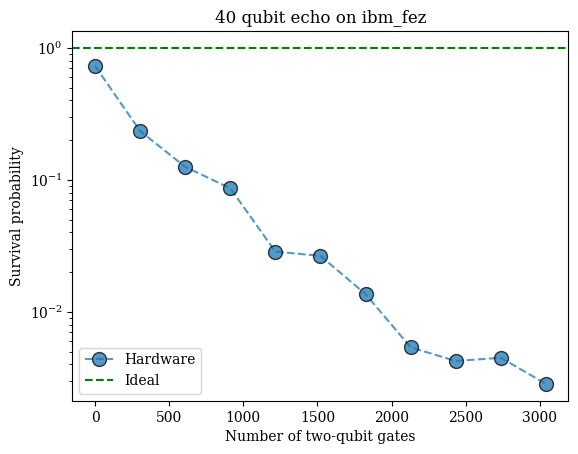

In [85]:
survival_probs = [counts.get("0" * len(qubits), 0) / nshots for counts in all_counts]
plt.semilogy(num_twoq, survival_probs, "--o", ms=10, mec="black", alpha=0.75, label="Hardware")
plt.axhline(1.0, label="Ideal", ls="dashed", color="green")
plt.xlabel("Number of two-qubit gates")
plt.ylabel("Survival probability")
plt.legend()
plt.title(
    f"{len(qubits)} qubit echo on {ibm_computer}"  # qubits \n" + "-".join(map(str, qubits))
);
# plt.savefig(f"echo_{computer.name}_{len(qubits)}_qubits_{nshots}_shots_num_twoq_gates.pdf")

In [ ]:
twoq_to_total = dict(zip(num_twoq, num_gates))
total_to_twoq = dict(zip(num_gates, num_twoq))

In [ ]:
fig, ax = plt.subplots()

survival_probs = [counts.get("0" * len(qubits), 0) / nshots for counts in all_counts]
ax.semilogy(num_twoq, survival_probs, "--o", ms=10, mec="black", alpha=0.75, label="Hardware")
ax.axhline(1.0, label="Ideal", ls="dashed", color="green")
ax.set_xlabel("Number of two-qubit gates")
ax.set_ylabel("Survival probability")
ax.legend()
ax.set_title(
    f"{len(qubits)} qubit echo on {ibm_computer}"  # qubits \n" + "-".join(map(str, qubits))
);

# ax2 = ax.twiny()
# ax2.set_xticks(num_gates)
# ax2.set_xlabel("Number of gates");

# twoq_to_total = dict(zip(num_twoq, num_gates))
# total_to_twoq = dict(zip(num_gates, num_twoq))
# f = lambda x: twoq_to_total[x]
# g = lambda x: total_to_twoq[x]

# ax1 = ax.secondary_xaxis(location="top", functions=(f, g))
# ax1.set_xlabel("Number of gates")

# plt.savefig(f"echo_{computer.name}_{len(qubits)}_qubits_{nshots}_shots.pdf")

## With dynamical decoupling

In [ ]:
sampler_dd = Sampler(computer)
sampler_dd.options.dynamical_decoupling.enable = True
sampler_dd.options.dynamical_decoupling.sequence_type = "XpXm"

In [ ]:
# job_dd = sampler_dd.run(to_run, shots=nshots)
job_dd = service.job("cuki416vaprs73fqr0sg")

In [ ]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]
survival_probs_dd = [counts.get("0" * len(qubits), 0) / nshots for counts in all_counts_dd]

In [ ]:
plt.semilogy(depths, survival_probs, "--o", ms=10, mec="black", alpha=0.75, label="Physical")
plt.semilogy(depths, survival_probs_dd, "--o", ms=10, mec="black", alpha=0.75, label="DD")
plt.xlabel("Depth")
plt.ylabel("Survival probability")
plt.legend()
plt.title(f"Loschmidt echo tests on {ibm_computer} qubits " + "-".join(map(str, qubits)));

## With readout error mitigation

In [ ]:
from qiskit_experiments.library import LocalReadoutError

In [ ]:
experiment = LocalReadoutError(qubits)
result = experiment.run(computer)

In [ ]:
mitigator = result.analysis_results("Local Readout Mitigator").value

In [ ]:
def apply_rem(counts: dict[str, int], mitigator: "qiskit_experiments.LocalReadoutMitigator") -> dict[str, int]:
    mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
    mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())
    return {k: round(v * nshots) for k, v in mitigated_probs.items()}

In [ ]:
all_counts_rem = [apply_rem(counts, mitigator) for counts in all_counts]
survival_probs_rem = [counts.get("0" * len(qubits), 0) / sum(counts.values()) for counts in all_counts_rem]

In [ ]:
all_counts_dd_rem = [apply_rem(counts, mitigator) for counts in all_counts_dd]
survival_probs_dd_rem = [counts.get("0" * len(qubits), 0) / sum(counts.values()) for counts in all_counts_dd_rem]

In [ ]:
plt.semilogy(depths, survival_probs, "--o", ms=10, mec="black", alpha=0.5, label="Physical")
plt.semilogy(depths, survival_probs_dd, "--o", ms=10, mec="black", alpha=0.5, label="DD")
plt.semilogy(depths, survival_probs_rem, "--o", ms=10, mec="black", alpha=0.5, label="REM")
plt.semilogy(depths, survival_probs_dd_rem, "--o", ms=10, mec="black", alpha=0.5, label="DD + REM")
plt.xlabel("Depth")
plt.ylabel("Survival probability")
plt.legend()
plt.title(f"Loschmidt echo tests on {ibm_computer} qubits " + "-".join(map(str, qubits)));

## With calibration

In [ ]:
import collections

import numpy as np
from scipy.optimize import curve_fit

In [ ]:
to_run[1].count_ops()

## (1) Run calibration circuits to determine coherent error

In [ ]:
calibration_depths = list(range(0, 100 + 1, 2))

calibration_circuits = []
for cdepth in calibration_depths:
    qreg = qiskit.QuantumRegister(len(qubits))
    calibration = qiskit.QuantumCircuit(qreg)
    for _ in range(cdepth):
        calibration.sx(qreg)
    # print(calibration.draw(fold=-1))
    if cdepth == 0:
        calibration.id(qreg)
    calibration.measure_active()
    compiled = qiskit.transpile(
        calibration,
        backend=computer,
        initial_layout=qubits,
        optimization_level=0,
    )
    calibration_circuits.append(compiled)

In [ ]:
job_calibration = sampler.run(calibration_circuits, shots=nshots)
# job_calibration = service.job("cukfckm0uq1s73bi7kt0")

In [ ]:
all_counts_calibration = [result.data.measure.get_counts() for result in job_calibration.result()]

In [ ]:
all_counts_calibration[0]

In [ ]:
def get_counts_for(qubit: int, qubits: list[int], counts: dict[str, int]) -> dict[str, int]:
    qubit_counts = collections.Counter()
    for k, v in counts.items():
        qubit_counts[k[qubits.index(qubit)]] += v
    return dict(qubit_counts)


In [ ]:
for counts_calibration in all_counts_calibration:
    for qubit in qubits:
        assert sum(get_counts_for(qubit, qubits, counts_calibration).values()) == nshots

In [ ]:
qubit_counts = {
    q: [get_counts_for(q, qubits, counts_calibration).get("0", 0) / nshots for counts_calibration in all_counts_calibration]
    for q in qubits
}

In [ ]:
for q in qubits:
    plt.plot(qubit_counts[q], "o", label=f"Qubit {q}", alpha=0.5)
plt.legend();

In [ ]:
def fit(xs, a=1.0, phi=0.0):
    return (a * np.cos(xs * (np.pi - phi) / 2) + 1) / 2

In [ ]:
xdim = int(np.ceil(np.sqrt(len(qubits))))
ydim = int(np.floor(np.sqrt(len(qubits))))

In [ ]:
fig, axes = plt.subplots(xdim, ydim, sharex=True, sharey=True, figsize=(17, 5))
axes = axes.flatten()

xvals = calibration_depths

for i, qubit in enumerate(qubits):
    axes[i].plot(xvals, qubit_counts[qubit], "o", label="Data")

    xs = np.linspace(xvals[0], xvals[-1], 1000)
    axes[i].plot(xs, fit(xs), label="Ideal")
    axes[i].set_title(f"Qubit {qubit}")
    axes[i].legend()

In [ ]:
phis = {}
for qubit in qubits:
    (a_opt, phi_opt), *_ = curve_fit(fit, xvals, qubit_counts[qubit], p0=[1.0, 0.0])
    phis[qubit] = phi_opt
phis

In [ ]:
fig, axes = plt.subplots(xdim, ydim, sharex=True, sharey=True, figsize=(17, 5))
axes = axes.flatten()

xvals = calibration_depths

for i, qubit in enumerate(qubits):
    axes[i].plot(xvals, qubit_counts[qubit], "o")

    xs = np.linspace(xvals[0], xvals[-1], 1000)
    axes[i].plot(xs, fit(xs), alpha=0.5, label="Uncalibrated")
    axes[i].plot(xs, fit(xs, phi=phis[qubit]), alpha=0.5, label="Calibrated")
    axes[i].set_title(f"Qubit {qubit}, $\phi^* = {round(phis[qubit], 5)}$")

plt.tight_layout()
plt.legend();

## (2) Apply correction to circuits

In [ ]:
def calibrate_sx(circuit: qiskit.QuantumCircuit, correction_angle: dict[int, float]) -> qiskit.QuantumCircuit:
    """Applies the per-qubit correction angle to square-root of NOT gates in the circuit,
    returning a new circuit.
    
    Args:
        circuit: Circuit to calibrate SX gates in.
        correction_angle: A dictionary of SX correction angles per qubit.
    """
    calibrated = circuit.copy_empty_like()

    for instruction in circuit.data:
        if instruction.name == "sx":
            qubit = instruction.qubits[0]._index
            calibrated.append(
                qiskit.circuit.CircuitInstruction(
                    qiskit.circuit.library.RXGate((np.pi + correction_angle[qubit]) / 2),
                    qubits=instruction.qubits,
                    clbits=instruction.clbits
                )
            )
        else:
            calibrated.append(instruction)
    return calibrated

## (3) Run benchmarks with calibrated gates

In [ ]:
calibration_depths = list(range(0, 1000 + 1, 32))

calibration_circuits = []
for cdepth in calibration_depths:
    qreg = qiskit.QuantumRegister(len(qubits))
    calibration = qiskit.QuantumCircuit(qreg)
    for _ in range(cdepth):
        calibration.sx(qreg)
    # print(calibration.draw(fold=-1))
    if cdepth == 0:
        calibration.id(qreg)
    calibration.measure_active()
    compiled = qiskit.transpile(
        calibration,
        backend=computer,
        initial_layout=qubits,
        optimization_level=0,
    )
    calibration_circuits.append(compiled)

In [ ]:
job_uc = sampler.run(calibration_circuits, shots=nshots)

In [ ]:
all_counts_uc = [result.data.measure.get_counts() for result in job_uc.result()]

In [ ]:
qubit_counts = {
    q: [get_counts_for(q, qubits, counts_calibration).get("0", 0) / nshots for counts_calibration in all_counts_uc]
    for q in qubits
}

In [ ]:
for q in qubits:
    plt.plot(qubit_counts[q], "--o", label=f"Qubit {q}", alpha=0.5)

In [ ]:
calibrated_circuits = []
for circuit in calibration_circuits:
    calibrated = calibrate_sx(circuit, phis)
    calibrated = qiskit.transpile(
        calibrated,
        backend=computer,
        optimization_level=0,
    )
    calibrated_circuits.append(calibrated)

In [ ]:
job_c = sampler.run(calibrated_circuits, shots=nshots)

In [ ]:
all_counts_c = [result.data.measure.get_counts() for result in job_c.result()]

In [ ]:
qubit_counts_c = {
    q: [get_counts_for(q, qubits, counts_calibration).get("0", 0) / nshots for counts_calibration in all_counts_c]
    for q in qubits
}

In [ ]:
plt.figure(figsize=(17, 5))
plt.subplot(121)
for q in qubits:
    plt.plot(qubit_counts[q], "--o", label=f"Qubit {q}", alpha=0.5)
plt.legend()
plt.xlabel("Depth")
plt.ylabel("Ground state population")
plt.title("Uncalibrated");

plt.subplot(122)
for q in qubits:
    plt.plot(qubit_counts_c[q], "--o", label=f"Qubit {q}", alpha=0.5)
plt.legend()
plt.xlabel("Depth")
plt.ylabel("Ground state population")
plt.title("Calibrated");

### (3.2) Quantum volume echo

In [ ]:
to_run_calibrated = [
    qiskit.transpile(calibrate_sx(circuit, phis), backend=computer, optimization_level=0) for circuit in to_run
]

In [ ]:
job_calibrated = sampler.run(to_run_calibrated, shots=nshots)

In [ ]:
all_counts_calibrated = [result.data.measure.get_counts() for result in job_calibrated.result()]
survival_probs_calibrated = [counts.get("0" * len(qubits), 0) / nshots for counts in all_counts_calibrated]

In [ ]:
plt.semilogy(depths, survival_probs, "--o", ms=10, mec="black", alpha=0.5, label="Physical")
plt.semilogy(depths, survival_probs_dd, "--o", ms=10, mec="black", alpha=0.5, label="DD")
plt.semilogy(depths, survival_probs_rem, "--o", ms=10, mec="black", alpha=0.5, label="REM")
plt.semilogy(depths, survival_probs_dd_rem, "--o", ms=10, mec="black", alpha=0.5, label="DD + REM")
plt.semilogy(depths, survival_probs_calibrated, "--o", ms=10, mec="black", alpha=0.5, label=r"Calibrated $\sqrt{X}$")
plt.xlabel("Depth")
plt.ylabel("Survival probability")
plt.legend()
plt.title(f"Loschmidt echo tests on {ibm_computer} qubits " + "-".join(map(str, qubits)));